<a href="https://colab.research.google.com/github/reshalfahsi/cheetah-robot-ppo/blob/master/Cheetah_Robot_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Teaching a Cheetah Robot to Run: Solving Continuous Control in Simulated Locomotion with Proximal Policy Optimization**

## **Important Libraries**

### **Install**

In [2]:
!apt -qq update
!apt -qq install -y libgl1-mesa-dev libglfw3

44 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev
Suggested packages:
  libosmesa6 libvulkan1
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgles-dev libgles1 libglfw3 libglvnd-core-dev libglvnd-dev
  libglx-dev libopengl-dev
0 upgraded, 10 newly installed, 0 to remove and 44 not upgraded.
Need to get 304 kB of archives.
After this operation, 2,890 kB of additional disk space will be used.
Selecting previously unselected package libglx-dev:amd64.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../0-libglx-dev_1.4.0-1_amd64.deb ...
Unpacking libg

In [3]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.6.12 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


In [4]:
!uv pip install -q --no-cache-dir --system lightning pyvirtualdisplay
!uv pip install -q --no-cache-dir --system mujoco gymnasium[mujoco]
!uv pip install -q --no-cache-dir --system pybullet moviepy parapara-anime
!uv pip install -q --no-cache-dir --system "ipython>=8.0.0"
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


### **Import**

In [5]:
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint

import gymnasium as gym

from google.colab.patches import cv2_imshow

from collections import deque
import matplotlib.animation
from IPython.display import Image, HTML
from moviepy.editor import VideoFileClip

import pybullet_envs
import pybullet as p
from base64 import b64encode
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from torch.distributions import Normal

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

  if event.key is 'enter':

  logger.warn(



## **Configuration**

In [6]:
ACTION_SPACE = [
    0, # Torque applied on the back thigh rotor
    1, # Torque applied on the back shin rotor
    2, # Torque applied on the back foot rotor
    3, # Torque applied on the front thigh rotor
    4, # Torque applied on the front shin rotor
    5, # Torque applied on the front foot rotor
]


# 0: z-coordinate of the front tip
# 1: angle of the front tip
# 2: angle of the back thigh
# 3: angle of the back shin
# 4: angle of the back foot
# 5: angle of the front thigh
# 6: angle of the front shin
# 7: angle of the front foot
# 8: velocity of the x-coordinate of front tip
# 9: velocity of the z-coordinate of front tip
# 10: angular velocity of the front tip
# 11: angular velocity of the back thigh
# 12: angular velocity of the back shin
# 13: angular velocity of the back foot
# 14: angular velocity of the front thigh
# 15: angular velocity of the front shin
# 16: angular velocity of the front foot
OBSERVATION_SPACE = 17


LR = 3e-4
LAMBDA = 0.95
GAMMA = 0.99
CLIP_EPSILON = 0.2
C1 = 0.5   # Value loss coefficient
C2 = 1e-2  # Entropy coefficient
BATCH_SIZE = 64
HIDDEN_DIM = 128
NUM_EPISODE = 360
MAXIMUM_STEP = 720
NUM_UPDATE_PER_EPISODE = 24
EPSILON = 1e-8


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CheetahAgent = None
TotalReward = 0

ENVIRONMENT_NAME = "HalfCheetah-v5"

In [7]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"


BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    "Cheetah_best.ckpt",
)

In [8]:
METRIC_TO_MONITOR = "reward"
METRIC_MODE = "max"

In [9]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 243002969


## **Dataset**

In [10]:
class RLDataset(data.Dataset):
    def __init__(self, rl_agent):
        super().__init__()

        self.env = gym.make(ENVIRONMENT_NAME)
        self.rl_agent = rl_agent

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        global TotalReward

        TotalReward = 0

        states = list()
        actions = list()
        rewards = list()
        dones = list()
        log_probs = list()
        values = list()
        next_values = list()

        obs, _ = self.env.reset()

        with torch.no_grad():
            for step in range(MAXIMUM_STEP):
                state = torch.from_numpy(obs).float().unsqueeze(0).to(DEVICE)
                dist = self.rl_agent.policy_network(state)
                action = dist.sample().squeeze(0)
                log_prob = dist.log_prob(action).sum(
                    dim=-1, keepdim=True
                ).squeeze(0)
                value = self.rl_agent.value_network(state).squeeze(0)

                next_obs, reward, terminated, truncated, _ = self.env.step(
                    action.detach().cpu().numpy()
                )
                done = int(terminated or truncated)

                states.append(state.squeeze(0))
                actions.append(action)
                log_probs.append(log_prob)
                values.append(value)
                rewards.append(torch.tensor(reward).unsqueeze(0))
                dones.append(torch.tensor(done).unsqueeze(0))

                obs = next_obs
                TotalReward += reward

                if done:
                    break

            next_value = self.rl_agent.value_network(
                torch.from_numpy(obs).float().unsqueeze(0).to(DEVICE)
            ).squeeze(0)
            values.append(next_value)


        states = torch.stack(states)
        actions = torch.stack(actions)
        log_probs = torch.stack(log_probs)
        values = torch.stack(values)
        rewards = torch.stack(rewards)
        dones = torch.stack(dones)

        return states, actions, log_probs, values, rewards, dones

In [11]:
class RLDataModule(L.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.dataset = RLDataset
        self.rl_agent = None

    def prepare_data(self):
        global CheetahAgent
        self.rl_agent = CheetahAgent

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = self.dataset(rl_agent=self.rl_agent)

    def train_dataloader(self):
        return data.DataLoader(self.train_dataset, batch_size=BATCH_SIZE)

## **Model**

### **Policy Network (Actor)**

In [12]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(OBSERVATION_SPACE, HIDDEN_DIM),
            nn.Tanh(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.Tanh(),
            nn.Linear(HIDDEN_DIM, len(ACTION_SPACE))
        )
        self.log_std = nn.Parameter(torch.zeros(len(ACTION_SPACE)))

    def forward(self, state):
        mean = self.net(state)
        std = torch.exp(self.log_std)
        dist = Normal(mean, std)
        return dist

### **Value Network (Critic)**

In [13]:
class ValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(OBSERVATION_SPACE, HIDDEN_DIM),
            nn.Tanh(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.Tanh(),
            nn.Linear(HIDDEN_DIM, 1)
        )

    def forward(self, state):
        return self.net(state)

### **Agent**

In [14]:
class AgentModule(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.policy_network = PolicyNetwork().to(DEVICE)
        self.value_network = ValueNetwork().to(DEVICE)

        self.automatic_optimization = False

        self.reward = list()

    def forward(self, state):
        # Deterministic policy for inference
        assert not self.training, "Inference only!"
        return self.policy_network(state).mean.detach().cpu().numpy()

    def compute_gae(self, rewards, values, dones):
        """
        Compute advantages using Generalized Advantage Estimation (GAE)
        """
        advantages = list()
        gae = 0

        for t in reversed(range(len(rewards))):
            delta = (
                rewards[t]
                + GAMMA * values[t + 1] * (1 - dones[t])
                - values[t]
            )
            gae = delta + GAMMA * LAMBDA * (1 - dones[t]) * gae
            advantages.append(gae)

        advantages = torch.stack(advantages[::-1])
        returns = advantages + values[:-1]

        return advantages, returns

    def training_step(self, batch, batch_nb):
        states, actions, log_probs, values, rewards, dones = batch

        states = states.squeeze(0)
        actions = actions.squeeze(0)
        log_probs = log_probs.squeeze(0)
        values = values.squeeze(0)
        rewards = rewards.squeeze(0)
        dones = dones.squeeze(0)

        advantages, returns = self.compute_gae(rewards, values, dones)
        advantages = (
            advantages - advantages.mean()
        ) / (advantages.std() + EPSILON)

        for _ in range(NUM_UPDATE_PER_EPISODE):
            indices = np.random.permutation((states).shape[0])
            for idx in range(0, (states).shape[0], BATCH_SIZE):
                batch_indices = indices[idx:idx + BATCH_SIZE]
                states_batch = states[batch_indices]
                actions_batch = actions[batch_indices]
                log_probs_batch = log_probs[batch_indices]
                advantages_batch = advantages[batch_indices]
                returns_batch = returns[batch_indices]

                # Policy update
                dist = self.policy_network(states_batch)
                new_log_probs_batch = dist.log_prob(actions_batch).sum(
                    dim=-1, keepdim=True
                )
                entropy = dist.entropy().mean()
                ratio = torch.exp(
                    new_log_probs_batch - log_probs_batch
                )
                surr1 = ratio * advantages_batch
                surr2 = torch.clamp(
                    ratio,
                    1 - CLIP_EPSILON,
                    1 + CLIP_EPSILON
                ) * advantages_batch
                policy_loss = -torch.min(surr1, surr2).mean()
                # Maximizing entropy encourages exploration
                policy_total_loss = policy_loss - C2 * entropy

                # Value update
                new_values_batch = self.value_network(states_batch)
                value_loss = ((new_values_batch - returns_batch) ** 2).mean()
                value_total_loss = C1 * value_loss

                # Optimize
                optimizer = self.optimizers()[0]
                optimizer.zero_grad()
                self.manual_backward(policy_total_loss)
                optimizer.step()

                optimizer = self.optimizers()[1]
                optimizer.zero_grad()
                self.manual_backward(value_total_loss)
                optimizer.step()

        self.log("reward", TotalReward, prog_bar=True)
        self.reward.append(TotalReward)

    def configure_optimizers(self):
        optimizer_policy = optim.Adam(self.policy_network.parameters(), lr=LR)
        optimizer_value = optim.Adam(self.value_network.parameters(), lr=LR)
        return [
            optimizer_policy,
            optimizer_value,
        ]

    def reward_curve(self):
        filename = f"{EXPERIMENT_DIR}reward_plot.png"
        plt.plot(self.reward, color="g")
        plt.title("Reward Curves")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.grid()
        plt.savefig(filename)
        plt.clf()
        img = cv2.imread(filename)
        cv2_imshow(img)

## **Training**

In [15]:
trainer = None

def _train_loop():
    global CheetahAgent, trainer

    seed_everything(SEED, workers=True)

    CheetahAgent = AgentModule()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=os.path.join(EXPERIMENT_DIR, "model"),
        mode=METRIC_MODE,
        filename="Cheetah_best",
    )
    callbacks.append(checkpoint)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=NUM_EPISODE,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )

    trainer.fit(CheetahAgent, ckpt_path=ckpt_path, datamodule=RLDataModule())

_train_loop()

INFO: Seed set to 243002969
INFO:lightning.fabric.utilities.seed:Seed set to 243002969
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | policy_network | PolicyNetwork | 19.6 K | train
1 | value_network  | ValueNetwork  | 18.9 K | train
---------------------------------------------------------
38.5 K    Trainable params
0         Non-trainable params
38.5 K    Total params
0.154     Total estimated model params size

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=360` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=360` reached.


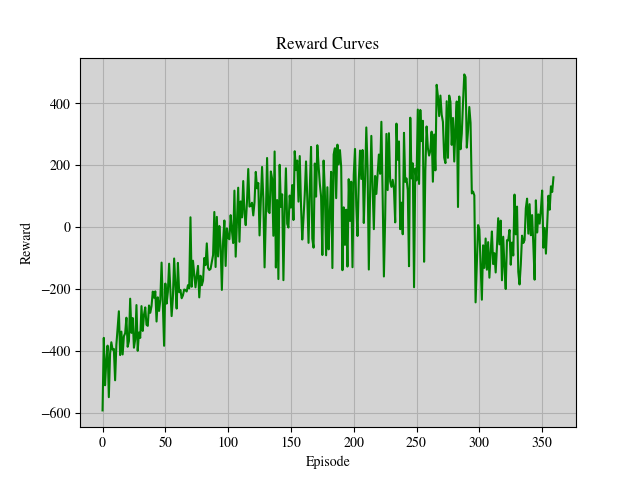

<Figure size 640x480 with 0 Axes>

In [16]:
trainer.strategy._lightning_module.reward_curve()

## **Inference**

In [17]:
def animate_agent(
    env, agent, output, dir=EXPERIMENT_DIR, max_steps=MAXIMUM_STEP
):
    obs, _ = env.reset(seed=SEED)
    for step in range(max_steps):
        obs = torch.tensor(obs).float().unsqueeze(0).to(DEVICE)
        action = agent(obs).squeeze(0)
        obs, _, terminated, truncated, _ = env.step(action)

        done = terminated or truncated
        if done:
            break

    env.close()
    del env

    path = glob.glob(os.path.join(dir, "*.mp4"))[0]
    if output == "html":
        mp4 = open(path, "rb").read()
        url = "data:video/mp4;base64," + b64encode(mp4).decode()
        return HTML(
            """<video width=400 controls><source src="%s" type="video/mp4"></video>""" % url
        )
    elif output == "gif":
        filename = f"{EXPERIMENT_DIR}inference.gif"
        videoClip = VideoFileClip(path)
        videoClip.write_gif(filename)
        with open(filename, "rb") as f:
            display(Image(data=f.read(), format="gif"))
    else:
        raise ValueError("Invalid output type")

In [18]:
p.connect(p.DIRECT)

CheetahAgent = AgentModule.load_from_checkpoint(BEST_MODEL_PATH)
if DEVICE == "cuda":
    CheetahAgent = CheetahAgent.cuda()
CheetahAgent.eval()

AgentModule(
  (policy_network): PolicyNetwork(
    (net): Sequential(
      (0): Linear(in_features=17, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=6, bias=True)
    )
  )
  (value_network): ValueNetwork(
    (net): Sequential(
      (0): Linear(in_features=17, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [ ]:
CheetahEnv = gym.make(ENVIRONMENT_NAME, render_mode="rgb_array")
CheetahEnv = gym.wrappers.RecordVideo(
    CheetahEnv,
    video_folder=EXPERIMENT_DIR,
    episode_trigger=lambda t: t % 10 == 0,
    disable_logger=True,
)
animate_agent(CheetahEnv, CheetahAgent, output="html")

In [ ]:
CheetahEnv = gym.make(ENVIRONMENT_NAME, render_mode="rgb_array")
CheetahEnv = gym.wrappers.RecordVideo(
    CheetahEnv,
    video_folder=EXPERIMENT_DIR,
    episode_trigger=lambda t: t % 10 == 0,
    disable_logger=True,
)
animate_agent(CheetahEnv, CheetahAgent, output="gif")